In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft
from numpy.fft import rfft, irfft, rfftfreq

# Dataset cyton_s32

## Load Data

### From CSV (not on github)

In [64]:
def load_eeg_temp_function(eeg, meta, classes, stim_duration=4, filter=False, sfreq = 1568):
    trials = meta[1:,:2]
    times = meta[1:,2]
    stim_end = int(stim_duration * sfreq)
    eeg = np.array([eeg.loc[eeg['time']>=t+0.07].drop(columns=['time']).to_numpy()[:stim_end].T for t in times]) # 0.07 might be due to the serial port delay
    if filter:
        eeg = mne.filter.notch_filter(eeg, Fs=sfreq, freqs=[60.0], verbose=0, method='fir', phase='zero')
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg
target_tab = {}
data_path = "../data/eeg_recordings/pilot_data/simon/cyton_s32/"
sfreq = 250.
duration = 5.0
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_eeg_temp_function(eeg, meta, classes, stim_duration=duration,filter=True,sfreq=sfreq)
target_by_trial = [list(target_tab.keys())] * 10

save_path = "../data/interim/pilot_data/simon/cyton_s32/"
np.save(save_path+'eeg.npy', eeg)
import pickle
with open(save_path+'target_tab.pkl', 'wb') as handle:
    pickle.dump(target_tab, handle)
with open(save_path+'target_by_trial.pkl', 'wb') as handle:
    pickle.dump(target_by_trial, handle)
eeg.shape, np.array(target_by_trial).shape

/var/folders/d4/jwh01wd56fx034z1_wlq76dr0000gn/T/ipykernel_9607/766751683.py:7: RuntimeWarning: filter_length (1651) is longer than the signal (1250), distortion is likely. Reduce filter length or filter a longer signal.
  eeg = mne.filter.notch_filter(eeg, Fs=sfreq, freqs=[60.0], verbose=0, method='fir', phase='zero')


((10, 32, 11, 1250), (10, 32, 2))

### From npy and pkl

In [54]:
import pickle
load_path = "../data/interim/pilot_data/simon/cyton_s32/"
eeg = np.load(load_path+'eeg.npy')
with open(load_path+'target_tab.pkl', 'rb') as handle:
    target_tab = pickle.load(handle)
with open(load_path+'target_by_trial.pkl', 'rb') as handle:
    target_by_trial = pickle.load(handle)
eeg.shape, np.array(target_by_trial).shape

((10, 32, 11, 1250), (10, 32, 2))

## Inspect photosensor data (as sanity check)

The light amplitude seems to fluctuate possibly due to auto brightness on the macbook

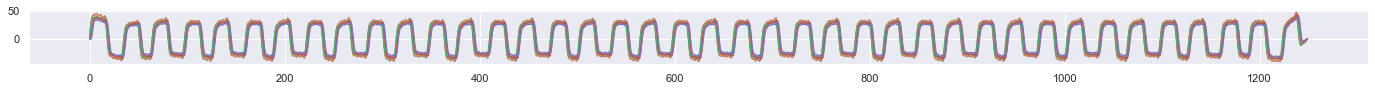

In [55]:
plt.figure(figsize=(24, 1))
plt.plot(eeg[0,0,9,:])
plt.plot(eeg[2,0,9,:])
plt.plot(eeg[4,0,9,:])
plt.plot(eeg[6,0,9,:])
plt.plot(eeg[9,0,9,:])

Occasionally there were bad trials, as the flashes would get stuck for a fraction of a second, quick but noticable

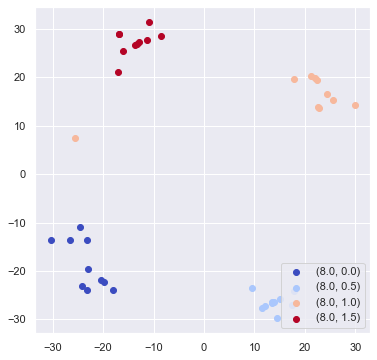

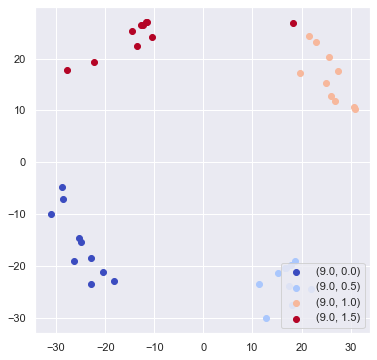

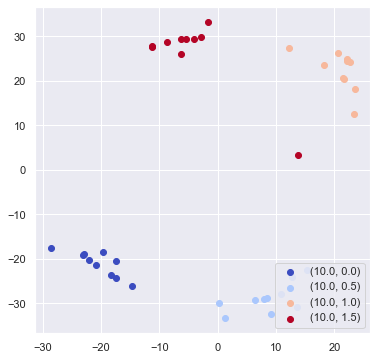

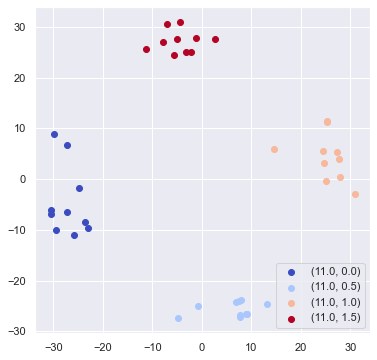

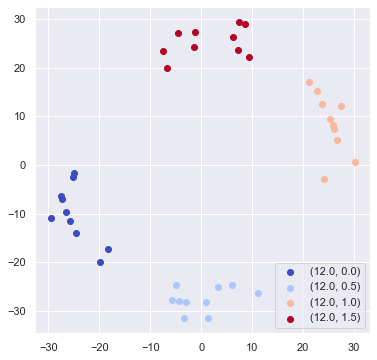

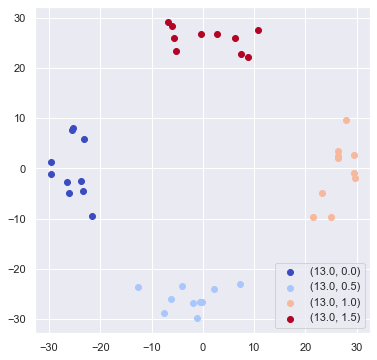

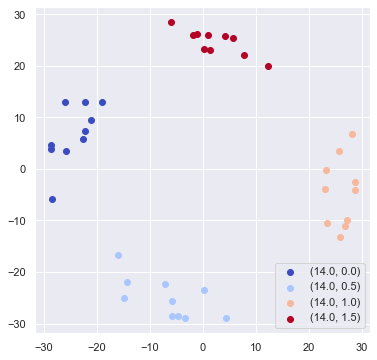

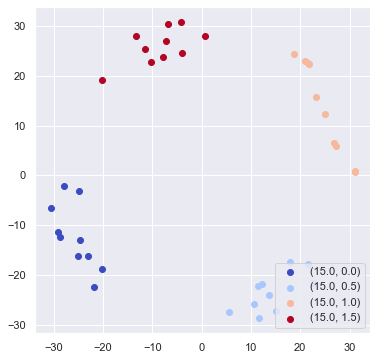

In [56]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,9,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,9,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

## Channel Data

### PSD N1P

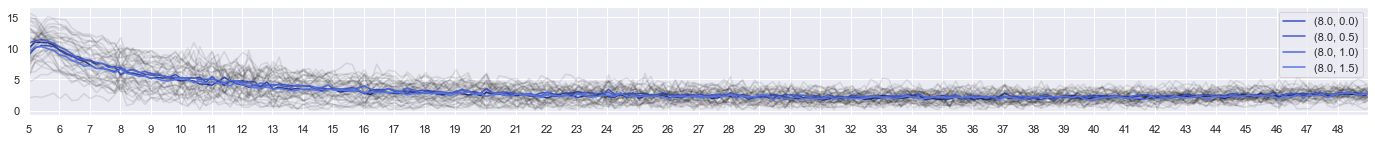

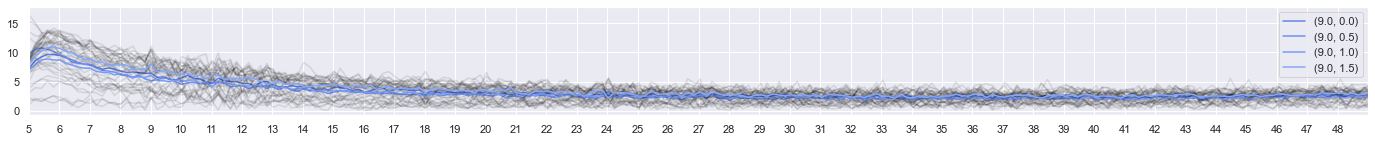

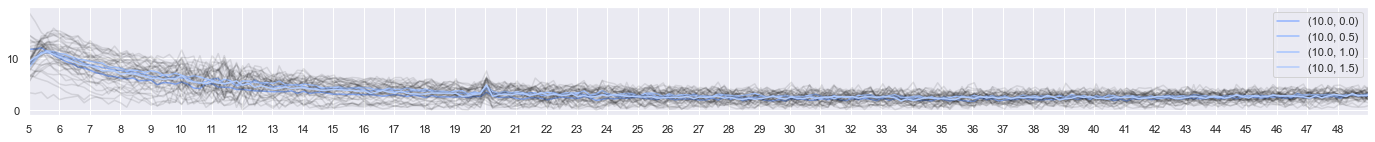

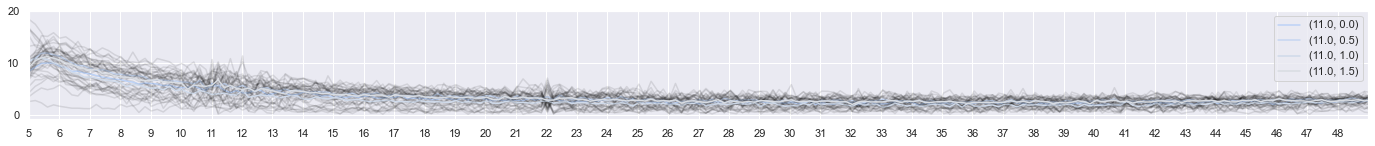

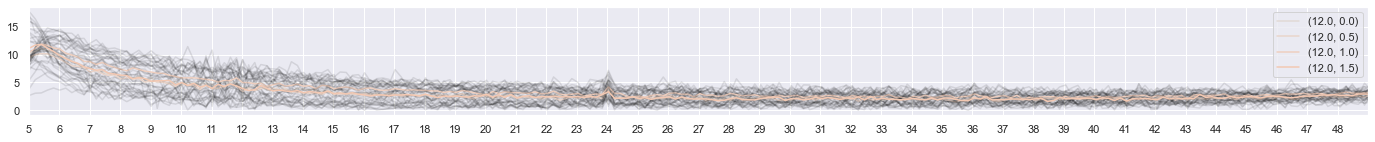

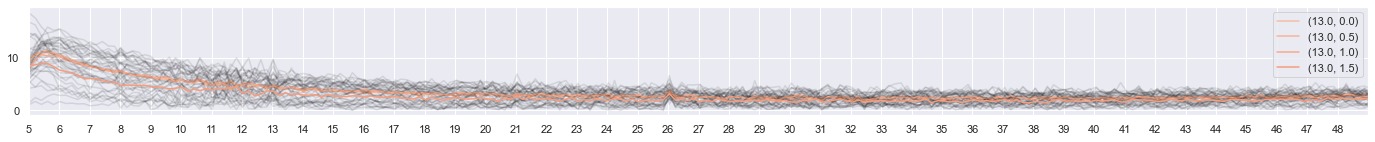

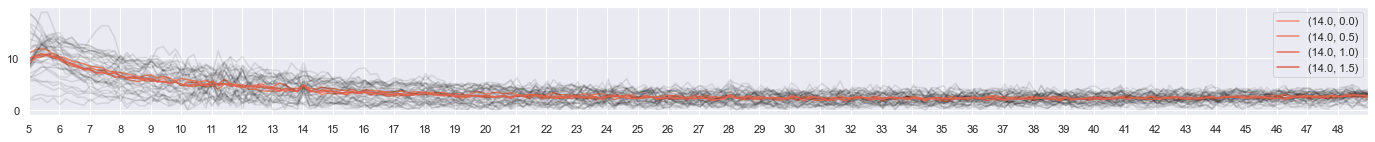

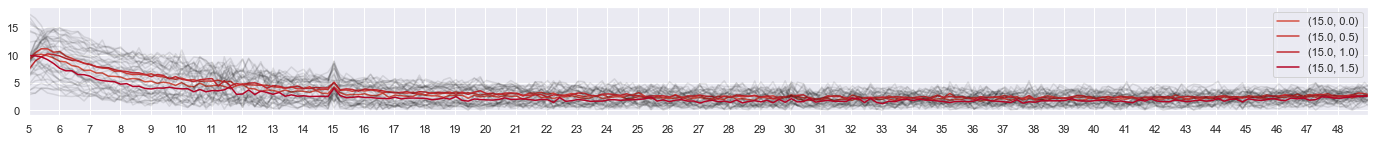

In [61]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,32))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,3,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,3,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

### Complex Spectra N1P

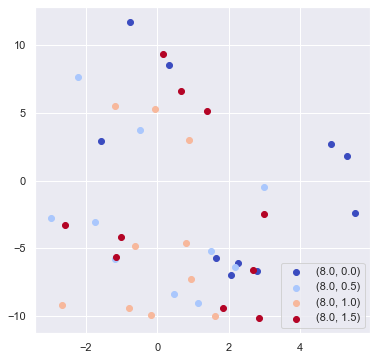

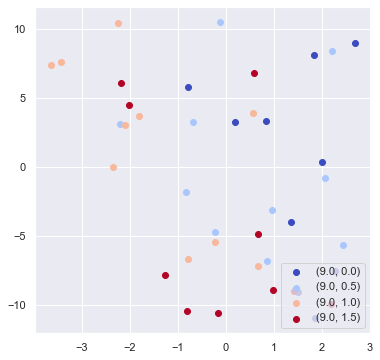

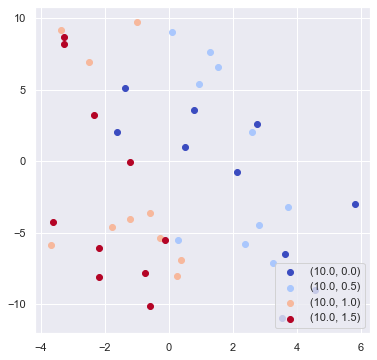

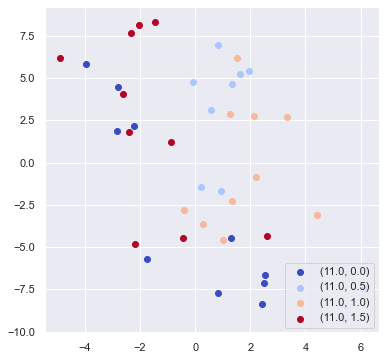

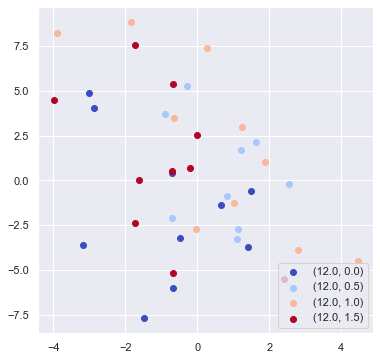

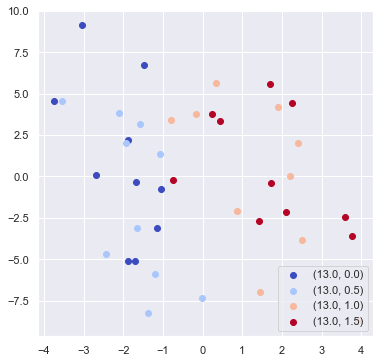

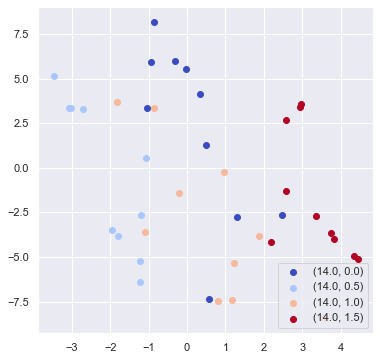

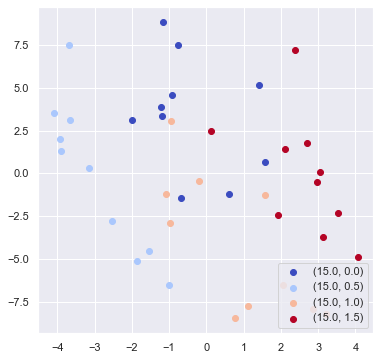

In [62]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))
    # plt.xlim(-0.07*np.pi, 0.07*np.pi)
    # plt.ylim(-0.07*np.pi, 0.07*np.pi)
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,3,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,3,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

# Data 6-05-22_run1

## Load Data

### From CSV

In [65]:
def load_eeg_temp_function(eeg, meta, classes, stim_duration=4, filter=False, sfreq = 1568):
    trials = meta[1:,:2]
    times = meta[1:,2]
    stim_end = int(stim_duration * sfreq)
    eeg = np.array([eeg.loc[eeg['time']>=t+0.07].drop(columns=['time']).to_numpy()[:stim_end].T for t in times]) # 0.07 might be due to the serial port delay
    if filter:
        eeg = mne.filter.notch_filter(eeg, Fs=sfreq, freqs=[60.0], verbose=0, method='fir', phase='zero')
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg
target_tab = {}
data_path = "../data/eeg_recordings/pilot_data/simon/cyton_data_quality/6-05-22_run1/"
sfreq = 250.
duration = 5.0
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_eeg_temp_function(eeg, meta, classes, stim_duration=duration,filter=True,sfreq=sfreq)
target_by_trial = [list(target_tab.keys())] * 10

save_path = "../data/interim/pilot_data/simon/cyton_data_quality/6-05-22_run1/"
np.save(save_path+'eeg.npy', eeg)
import pickle
with open(save_path+'target_tab.pkl', 'wb') as handle:
    pickle.dump(target_tab, handle)
with open(save_path+'target_by_trial.pkl', 'wb') as handle:
    pickle.dump(target_by_trial, handle)
eeg.shape, np.array(target_by_trial).shape

/var/folders/d4/jwh01wd56fx034z1_wlq76dr0000gn/T/ipykernel_9607/2724228650.py:7: RuntimeWarning: filter_length (1651) is longer than the signal (1250), distortion is likely. Reduce filter length or filter a longer signal.
  eeg = mne.filter.notch_filter(eeg, Fs=sfreq, freqs=[60.0], verbose=0, method='fir', phase='zero')


((10, 4, 11, 1250), (10, 4, 2))

### From npy and pkl

In [ ]:
import pickle
load_path = "../data/interim/pilot_data/simon/cyton_s32/"
eeg = np.load(load_path+'eeg.npy')
with open(load_path+'target_tab.pkl', 'rb') as handle:
    target_tab = pickle.load(handle)
with open(load_path+'target_by_trial.pkl', 'rb') as handle:
    target_by_trial = pickle.load(handle)
eeg.shape, np.array(target_by_trial).shape

## Channel Data

### PSD N1P

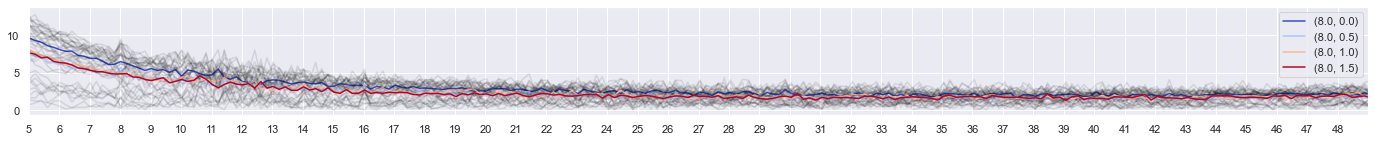

In [67]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,psd.shape[1]))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,3,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,3,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

### Complex Spectra N1P

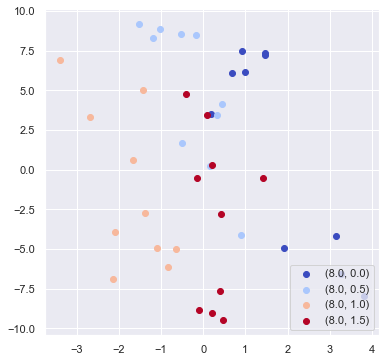

In [70]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(eeg.shape[1]//4):
    k *= 4
    plt.figure(figsize=(6, 6))
    # plt.xlim(-0.07*np.pi, 0.07*np.pi)
    # plt.ylim(-0.07*np.pi, 0.07*np.pi)
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,3,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,3,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')